# Imports

In [46]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp
#import cgl_thalamic as ct
import cgl1 as c1

import importlib
import lib
importlib.reload(sys.modules['lib.lib'])
from lib.lib import get_phase, rhs_avg, _redu, _redu_moving, _redu_moving_avg, _redu_moving_avg2

from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp

import scipy as sp
from scipy.optimize import root,bisect

import copy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [47]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spatial
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier


def intersection(points1, points2, eps):
    tree = spatial.KDTree(points1)
    distances, indices = tree.query(points2, k=1, distance_upper_bound=eps)
    intersection_points = tree.data[indices[np.isfinite(distances)]]
    return intersection_points


def cluster(points, cluster_size):
    dists = dist.pdist(points, metric='sqeuclidean')
    linkage_matrix = hier.linkage(dists, 'average')
    groups = hier.fcluster(linkage_matrix, cluster_size, criterion='distance')
    return np.array([points[cluster].mean(axis=0)
                     for cluster in clusterlists(groups)])


def contour_points(contour, steps=1):
    for linecol in contour.collections:
        
        if len(linecol.get_paths()) == 0:
            return 0
    
    return np.row_stack([path.interpolated(steps).vertices
                         for linecol in contour.collections
                         for path in linecol.get_paths()])

def clusterlists(T):
    '''
    http://stackoverflow.com/a/2913071/190597 (denis)
    T = [2, 1, 1, 1, 2, 2, 2, 2, 2, 1]
    Returns [[0, 4, 5, 6, 7, 8], [1, 2, 3, 9]]
    '''
    groups = collections.defaultdict(list)
    for i, elt in enumerate(T):
        groups[elt].append(i)
    return sorted(groups.values(), key=len, reverse=True)

In [48]:
reload(c1);reload(nm);reload(rp);reload(lib)
nmc = nm.nmCoupling;rsp = rp.Response

# Definitions

## Forcing

In [4]:
def ff(x):
    return np.sin(x)
    #return np.mod(om*x,2*np.pi) # works for 1:2
    #return np.sin(om*x/4)**100 # works for 1:2
    #return 5*(np.sin(om*x)+np.cos(om*x)+np.sqrt(2)*np.sin(om*x*4))

def ff2(x,om):
    return 25*np.sin(om*x/1.6)

def ff3(x):
    return np.mod(x,2*np.pi) # works for 1:2

def ff4(x):
    y = np.mod(x,2*np.pi)
    return np.heaviside(y,0)*np.heaviside(np.pi-y,0)

def ff5_raw(x,s=1):
    x = np.mod(x,2*np.pi)
    tot = 0
    for i in range(-10,10+1):
        #tot += 1/(np.sqrt(np.pi)*s)*np.exp(-(((x+i*2*np.pi))/s)**2)
        tot -= np.exp(-(((x+i*2*np.pi))/s)**2)
    return tot

x_temp,dx_temp = np.linspace(-np.pi,np.pi,1000,retstep=True)
ff5_mean = np.sum(ff5_raw(x_temp))*dx_temp/(2*np.pi)

def ff5(x,s=1):
    x = np.mod(x,2*np.pi)
    tot = 0
    for i in range(-10,10+1):
        #tot += 1/(np.sqrt(np.pi)*s)*np.exp(-(((x+i*2*np.pi))/s)**2)
        tot -= np.exp(-(((x+i*2*np.pi))/s)**2)
    return tot - ff5_mean

## Dicts

In [5]:
pd1 = {'sig':.08,'rho':.12,'mu':1,'om':1,'om_fix':1}

In [6]:
trunc_order = 6
i_f_list = np.ones(trunc_order+2).astype(bool)
i_f_list[0] = False#;i_f_list[1]=True
i_f_list = list(i_f_list)

kws1 = {'var_names':['x','y'],
        'rhs':c1.rhs,
        'init':np.array([1,0,2*np.pi]),
        'TN':2000,
        'idx':0,
        'model_name':'cglf0',
        'trunc_order':trunc_order,
        'recompute_list':[],
        'g_forward':False,
        'z_forward':False,
        'i_forward':i_f_list,
        'i_bad_dx':True,
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'forcing_fn':ff5}

In [7]:
def conv(y,s=5000):
    z_temp = np.linspace(-5,5,s)
    ker = np.exp(-z_temp**2)
    ker /= np.sum(ker)
    return np.convolve(y,ker,mode='same')

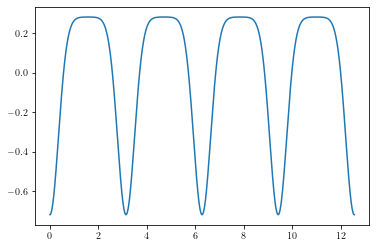

In [8]:
fig,axs = plt.subplots()
t_temp = np.linspace(0,4*np.pi,10000)
axs.plot(t_temp,ff5(2*t_temp))

In [9]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

## 

PL exist full

## PL exist reduced

In [10]:
def pl_exist(eps,del1,a,th_init=0,return_data=False):

    system1 = a.system1
    
    if eps == 0:
        return -1
    # every intersection point must be within eps of a point on the other
    # contour path
    err = 1
    
    # cluster together intersection points so that the original points in each flat
    # cluster have a cophenetic_distance < cluster_size
    cluster_size = 100
    
    th_temp = np.linspace(0, 2*np.pi, 200)
    ps_temp = np.linspace(-.25, .25, 200)
    
    TH,PS = np.meshgrid(th_temp,ps_temp)

    Z1,Z2 = rhs_avg(0,[TH,PS],a,eps,del1)
    # Z1 = 0
    # Z2 = system1.kappa_val*PS
    
    # for i in range(len(a.hz_lam)):
    #     Z1 += eps*PS**i*a.hz_lam[i](TH)*a._n[1]
    #     Z2 += eps*PS**i*a.hi_lam[i](TH)*a._n[1]
    # Z1 -= del1

    #fig,axs = plt.subplots(1,1,figsize=(4,3))
    contour1 = plt.contour(TH,PS,Z1,levels=[0],linewidths=.5,colors='k')
    contour2 = plt.contour(TH,PS,Z2,levels=[0],linewidths=.5,colors='b')
    #print('eps,del',eps,del1)
    #plt.show()

    if return_data:
        return plt

    plt.close()
    
    #contour1 = plt.contour(Z1, colors='k')
    #contour2 = plt.contour(Z2, colors='r')

    #print(intersection_points)

    points1 = contour_points(contour1)
    points2 = contour_points(contour2)
    
    if isinstance(points1, int) or isinstance(points2, int):
        
        return -1
        
    else:
        intersection_points = intersection(points1, points2, err)

        if len(intersection_points) == 0:
            return -1
        else:
            return 1
            print('intersection_points',intersection_points)
            intersection_points = cluster(intersection_points, cluster_size)
            #plt.close()

## 

PL exist reduced

## PL exist full

In [11]:
def pl_exist_full(eps,del1,a,T=1000,th_init=3,plot=False):
    dt = .02;#max(250,1/eps11)
    t = np.arange(0,T,dt)

    y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

    pd2 = copy.deepcopy(system2.pardict)
    pd2['om1'] += del1
    
    sol_full = solve_ivp(_full,[0,t[-1]],y0,method='LSODA',
                         t_eval=t,args=(eps,system1.pardict,
                                        system2.pardict,del1,system2),rtol=5e-6,atol=5e-6)

    # estimate phase for each model and compare phase difference
    tp, phase1 = get_phase(sol_full,skipn=30,system1=system1)
    forcing_phase = np.mod((a._m[1]+del1)*np.linspace(0,tp[-1],len(tp)),2*np.pi*a._m[1])
    y = np.mod(phase1*2*np.pi-a.om*forcing_phase+np.pi,2*np.pi)

    if plot:
        fig,axs = plt.subplots()
        axs.plot(y)
        plt.show()
    
    TN = len(forcing_phase)
    jumps = len(np.where(np.abs(np.diff(y[int(TN/2):]))>np.pi)[0])
    #print('eps,jumps,del1',eps,jumps,del1)
    if jumps > 0:
        return 1
    elif jumps <= 0:
        return -1

## Get tongue

In [12]:
def get_tongue(del_list,a,deps=.002,max_eps=.3,min_eps=0):

    ve_exist = np.zeros(len(del_list))
    
    for i in range(len(del_list)):
        print(np.round((i+1)/len(del_list),2),'    ',end='\r')

        if np.isnan(ve_exist[i-1]):
            eps = 0
        else:
            eps = max(ve_exist[i-1] - 2*deps,0)
        while not(pl_exist(eps,del_list[i],a)+1)\
        and eps <= max_eps:
            eps += deps
            #print('existloop',eps)
        if eps >= max_eps:
            ve_exist[i] = np.nan
        else:
            deps2 = deps
            flag = False
            while not(flag) and deps2 < .2:
                #print('while loop',deps2)
                try:
                    out = bisect(pl_exist,0,eps+deps2,args=(del_list[i],a))
                    flag = True
                except ValueError:
                    deps2 += .001
            if flag:
                ve_exist[i] = out
            else:
                ve_exist[i] = np.nan
    print('')
    return del_list,ve_exist

## RHS Full

In [27]:
def _full(t,y,a,eps=0,del1=0):
    pd1 = a.system1.pardict
    omf = a._m[1]
    omx = a._n[1]
    ofix = a.system1.pardict['om_fix0']

    u = a.system1.forcing_fn(t*(del1+omf))
    
    out1 = c1.rhs(t,y,pd1,'val',0) + eps*ofix*omx*np.array([u,0])
    return np.array(list(out1))

## Frequency estimate

In [28]:
def freq_est(t,y,transient=.5,width=50,height=-np.inf,return_idxs=False):
    """ for use only with the frequency ratio plots"""
    peak_idxs = sp.signal.find_peaks(y,width=width,height=height)[0]
    peak_idxs = peak_idxs[int(len(peak_idxs)*transient):]
    freq = 2*np.pi/np.mean(np.diff(t[peak_idxs]))
    
    if return_idxs:
        return freq,peak_idxs
    else:
        return freq

# Run response

In [29]:
system1 = rsp(pardict=copy.deepcopy(pd1),**copy.deepcopy(kws1))

* Loading LC data...
self.T 6.283185307179586 omfix 1.0000000000000262
* Loading monodromy...
* Floquet Exponent kappa =-0.16000000000008133
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Fourier modes response

Text(0.5, 0.98, 'Only single frequency Fourier components exist for CGL')

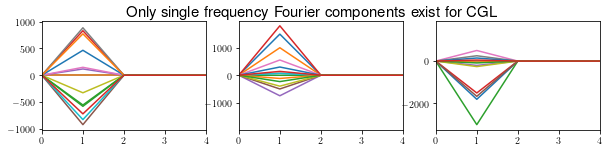

In [16]:
fig,axs = plt.subplots(1,3,figsize=(10,2))
for k in range(system1.miter):
    axs[0].plot(np.fft.fft(system1.g['dat'][k][:,0]).real)
    axs[0].plot(np.fft.fft(system1.g['dat'][k][:,0]).imag)
    axs[1].plot(np.fft.fft(system1.z['dat'][k][:,0]).real)
    axs[1].plot(np.fft.fft(system1.z['dat'][k][:,0]).imag)
    axs[2].plot(np.fft.fft(system1.i['dat'][k][:,0]).real)
    axs[2].plot(np.fft.fft(system1.i['dat'][k][:,0]).imag)
axs[0].set_xlim(0,4)
axs[1].set_xlim(0,4)
axs[2].set_xlim(0,4)

plt.suptitle('Only single frequency Fourier components exist for CGL',fontsize=15)

# 1:1

In [21]:
a11 = nmc(system1,None,
        #recompute_list=['p_data_cglf0','h_data_cglf0'],
        _n=('om0',1),_m=('om1',1),
        NP=300,NH=300)

e1,e2
psi**6*zx0_6(t) + psi**5*zx0_5(t) + psi**4*zx0_4(t) + psi**3*zx0_3(t) + psi**2*zx0_2(t) + psi*zx0_1(t) + zx0_0(t)
psi**6*ix0_6(t) + psi**5*ix0_5(t) + psi**4*ix0_4(t) + psi**3*ix0_3(t) + psi**2*ix0_2(t) + psi*ix0_1(t) + ix0_0(t)

0 imp0 for z zx0_0(th0)
0 imp0 for i ix0_0(th0)
1 imp0 for z zx0_1(th0)
1 imp0 for i ix0_1(th0)
2 imp0 for z zx0_2(th0)
2 imp0 for i ix0_2(th0)
3 imp0 for z zx0_3(th0)
3 imp0 for i ix0_3(th0)
4 imp0 for z zx0_4(th0)
4 imp0 for i ix0_4(th0)
5 imp0 for z zx0_5(th0)
5 imp0 for i ix0_5(th0)
6 imp0 for z zx0_6(th0)
6 imp0 for i ix0_6(th0)

hz0,hi0,imp
0 uf(t)*zx0_0(t + th0)
1 uf(t)*zx0_1(t + th0)
2 uf(t)*zx0_2(t + th0)
3 uf(t)*zx0_3(t + th0)
4 uf(t)*zx0_4(t + th0)
5 uf(t)*zx0_5(t + th0)
6 uf(t)*zx0_6(t + th0)

0 ix0_0(t + th0)*uf(t)
1 ix0_1(t + th0)*uf(t)
2 ix0_2(t + th0)*uf(t)
3 ix0_3(t + th0)*uf(t)
4 ix0_4(t + th0)*uf(t)
5 ix0_5(t + th0)*uf(t)
6 ix0_6(t + th0)*uf(t)



## Tongue

In [22]:
d1 = np.linspace(-10,-1,5,endpoint=False)
del_list_11a,ve_list_11a = get_tongue(2**d1,a11,deps=.01,max_eps=.4)
del_list_11b,ve_list_11b = get_tongue(-2**d1,a11,deps=.01,max_eps=.4)

1.0     
1.0     


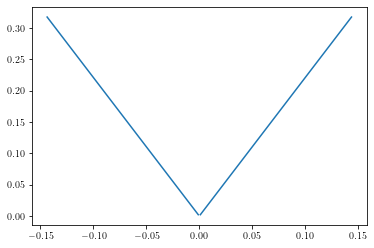

In [23]:
fig,axs = plt.subplots()
axs.plot(del_list_11a,ve_list_11a,color='tab:blue')
axs.plot(del_list_11b,ve_list_11b,color='tab:blue')
#axs.scatter([-.1],[.1])

## Frequency ratio

Note that a better match between full and reduced can be obtained by extending the simulation time (as opposed to reducing the time step)

In [30]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val11 = .1

del_range11 = np.linspace(-.2,.2,10)

th_init = 3

dt = .01;T=1000
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

fr_full11 = []
fr_redu11 = []

for i in range(len(del_range11)):
    
    args11 = [a11,eps_val11,del_range11[i]]
    
    solf11 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args11,),**kw_sim)
    solr11a = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args11,),**kw_sim)
    #solr11b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args11,),**kw_sim)
    #solr11_0 = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args11,1),**kw_sim)

    timef = t*(a11._m[1]+del_range11[i])
    timer = t*(a11._n[1]+del_range11[i])
    freq_force = freq_est(t,a11.system1.forcing_fn(timef))
    freq_full = freq_est(t,solf11.y.T[:,0])
    freq_redu = freq_est(t,np.mod(solr11a.y.T[:,0]+timer,2*np.pi))
    
    print(freq_full/freq_force,freq_redu/freq_force)

    # fig,axs = plt.subplots()
    # axs.plot(t,solf11.y.T[:,0])
    # axs.plot(t,np.mod(solr11a.y.T[:,0]+timer,2*np.pi))
    # axs.set_xlim(t[-1]-50,t[-1])
    # # axs.scatter(t[peak_idxs_full],solf11.y.T[peak_idxs_full,0])
    # plt.show()

    fr_full11.append(freq_full/freq_force)
    fr_redu11.append(freq_redu/freq_force)

fr_full11 = np.asarray(fr_full11)
fr_redu11 = np.asarray(fr_redu11)

1.2484928508028492 1.2482165688892977
1.1810248513951473 1.1808350484900838
1.1184221584043073 1.1182860503997147
1.0562847480942283 1.0556264679906775
1.0000000000000002 1.0
1.0 1.0
0.944933016318619 0.9453121268567607
0.902825418755776 0.903281796858916
0.8677460473347508 0.8677460473347508
0.8351720239056696 0.8352732119058196


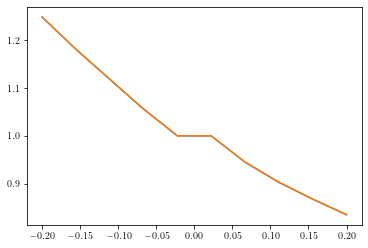

In [31]:
fig,axs = plt.subplots()
axs.plot(del_range11,fr_full11)
axs.plot(del_range11,fr_redu11)

## Verify

In [32]:
eps11 = .1
del11 = 0.01
th_init = 3

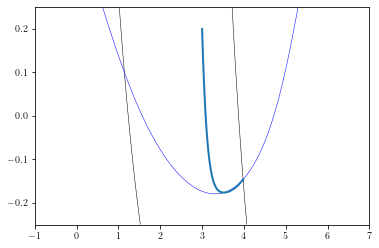

In [33]:
t0 = np.arange(0,10000,.02)

plt = pl_exist(eps11,del11,a11,return_data=True)

out1 = solve_ivp(rhs_avg,[t0[0],t0[-1]],[3,.2],t_eval=t0,args=(a11,eps11,del11))
plt.plot(np.mod(out1.y.T[:,0],2*np.pi),out1.y.T[:,1],lw=2)

plt.xlim(-1,7)

plt.show()

In [34]:
dt = .02;T=500
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

args11 = [a11,eps11,del11]

sol_full = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args11,),
                     **kw_sim)

solr11 = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args11,),**kw_sim)
# solr11_0 = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args11,1),**kw_sim)
# solq11 = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args11,),**kw_sim)

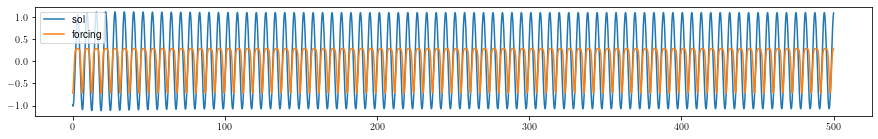

In [36]:
fig,axs = plt.subplots(figsize=(15,2))
axs.plot(t,sol_full.y.T[:,0],label='sol')
axs.plot(t,a11.system1.forcing_fn(t*(1+del11)),label='forcing')
#axs.set_xlim(t[-1]-100,t[-1])
axs.legend()

In [37]:
# estimate phase for each model and compare phase difference
tp, phase1 = get_phase(t,sol_full.y.T,skipn=1,system1=system1)
#phase1 = np.arctan2(sol_full.y.T[:,1],sol_full.y.T[:,0])

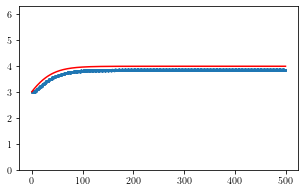

In [38]:
fig,axs = plt.subplots(figsize=(5,3)); axs = np.asarray([axs])
#forcing_phase = np.mod((a._m[1]+del11)*np.linspace(0,t[-1],len(phase1)),2*np.pi)
forcing_phase = np.mod((1+del11)*np.linspace(0,tp[-1],len(tp)),2*np.pi*1)
y = np.mod(phase1-forcing_phase,2*np.pi)

axs[0].scatter(tp,y,s=1,alpha=.25)
axs[0].plot(solr11.t,np.mod(solr11.y.T[:,0],2*np.pi),color='r')
# axs[0].plot(solr11_0.t,np.mod(solr11_0.y.T[:,0],2*np.pi),color='g')
# axs[0].plot(solq11.t,np.mod(solq11.y.T[:,0] - solq11.y.T[:,2],2*np.pi),color='orange')

axs[0].set_ylim(0,2*np.pi)

#axs[0].set_xlim(0,100)

x2 = np.linspace(0,2*np.pi,1000)
#axs[1].axhline(0,0,2*np.pi,color='gray')
#axs[1].plot(x2,ct_redu(0,x2,eps11,system11a,del11,a))

# axs[1].plot(sol_full.y.T[:,0],sol_full.y.T[:,1])
# axs[2].plot(t,np.abs(system11b(t,del11)-sol_full.y.T[:,0]))
# axs[2].set_xlim(t[-1]-50,t[-1])

# 2:1

In [39]:
a21 = nmc(system1,None,
        _n=('om0',2),_m=('om1',1),
        NP=500,NH=500)

e1,e2
psi**6*zx0_6(t) + psi**5*zx0_5(t) + psi**4*zx0_4(t) + psi**3*zx0_3(t) + psi**2*zx0_2(t) + psi*zx0_1(t) + zx0_0(t)
psi**6*ix0_6(t) + psi**5*ix0_5(t) + psi**4*ix0_4(t) + psi**3*ix0_3(t) + psi**2*ix0_2(t) + psi*ix0_1(t) + ix0_0(t)

0 imp0 for z zx0_0(th0)
0 imp0 for i ix0_0(th0)
1 imp0 for z zx0_1(th0)
1 imp0 for i ix0_1(th0)
2 imp0 for z zx0_2(th0)
2 imp0 for i ix0_2(th0)
3 imp0 for z zx0_3(th0)
3 imp0 for i ix0_3(th0)
4 imp0 for z zx0_4(th0)
4 imp0 for i ix0_4(th0)
5 imp0 for z zx0_5(th0)
5 imp0 for i ix0_5(th0)
6 imp0 for z zx0_6(th0)
6 imp0 for i ix0_6(th0)

hz0,hi0,imp
0 uf(t)*zx0_0(2*t + th0)
1 uf(t)*zx0_1(2*t + th0)
2 uf(t)*zx0_2(2*t + th0)
3 uf(t)*zx0_3(2*t + th0)
4 uf(t)*zx0_4(2*t + th0)
5 uf(t)*zx0_5(2*t + th0)
6 uf(t)*zx0_6(2*t + th0)

0 ix0_0(2*t + th0)*uf(t)
1 ix0_1(2*t + th0)*uf(t)
2 ix0_2(2*t + th0)*uf(t)
3 ix0_3(2*t + th0)*uf(t)
4 ix0_4(2*t + th0)*uf(t)
5 ix0_5(2*t + th0)*uf(t)
6 ix0_6(2*t + th0)*uf(t)



## Tongue

In [40]:
d1 = np.linspace(-15,0,10,endpoint=False)
#dtemp = np.linspace(-1e-3,1e-3,31)

del_list_21a,ve_list_21a = get_tongue(2**d1,a21,deps=.01,max_eps=.3)
del_list_21b,ve_list_21b = get_tongue(-2**d1,a21,deps=.01,max_eps=.3)

1.0     
1.0     


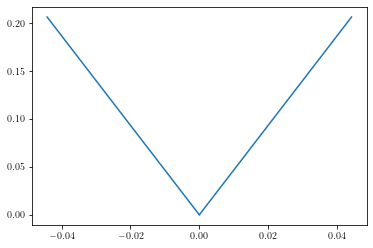

In [41]:
fig,axs = plt.subplots()
axs.plot(del_list_21a,ve_list_21a,color='tab:blue')
axs.plot(del_list_21b,ve_list_21b,color='tab:blue')
#axs.set_xscale('symlog')
#axs.set_xscale('log')
#axs.set_xlim(4e-6,2e-5)

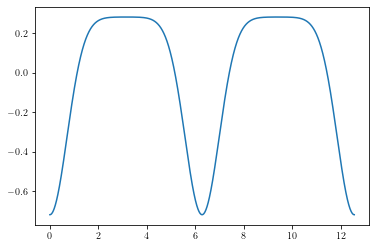

In [43]:
fig,axs = plt.subplots()
axs.plot(t_temp,a21.system1.forcing_fn(t_temp))

## Frequency ratio

In [49]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val21 = .1

del_range21 = np.linspace(-.03,.03,10)
# del_range21 = [-.015]

th_init = 3

dt = .01;T=1000
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

fr_full21 = []
fr_redu21 = []
fr_redu21b = []
fr_redu21c = []

for i in range(len(del_range21)):
    
    args21 = [a21,eps_val21,del_range21[i]]
    
    solf21 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args21,),**kw_sim)    
    solr21a = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args21,),**kw_sim)
    solr21b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args21,),**kw_sim)
    # solr21c = solve_ivp(_redu_moving,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args21,),**kw_sim)
    #solr21_0 = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args21,1),**kw_sim)

    timef = t*(a21._m[1]+del_range21[i])
    timer = t*a21._n[1]*(1+del_range21[i]/a21._m[1])
    freq_force = freq_est(t,a21.system1.forcing_fn(timef))
    freq_full = freq_est(t,solf21.y.T[:,0])
    freq_redu = freq_est(t,np.mod(solr21a.y.T[:,0]+timer,2*np.pi))
    freq_redub = freq_est(t,np.mod(solr21b.y.T[:,0],2*np.pi))
    # freq_reduc = freq_est(t,np.mod(solr21c.y.T[:,0]+timer,2*np.pi))

    print(del_range21[i],freq_full/freq_force,freq_redu/freq_force)

    # fig,axs = plt.subplots()
    # axs.plot(t,solf21.y.T[:,0])
    # axs.plot(t,np.mod(solr21a.y.T[:,0]+timer,2*np.pi))
    # axs.plot(t,np.mod(solr21b.y.T[:,0],2*np.pi))
    # axs.plot(t,a21.system2(timef))
    # axs.set_xlim(t[-1]-50,t[-1])
    # #axs.scatter(t[peak_idxs_full],solf21.y.T[peak_idxs_full,0])
    # #axs.scatter(t[peak_idxs_full],np.mod(solr21a.y.T[peak_idxs_full,0],2*np.pi))
    # plt.show()

    fr_full21.append(freq_full/freq_force)
    fr_redu21.append(freq_redu/freq_force)
    fr_redu21b.append(freq_redub/freq_force)
    # fr_redu21c.append(freq_reduc/freq_force)

fr_full21 = np.asarray(fr_full21)
fr_redu21 = np.asarray(fr_redu21)
fr_redu21b = np.asarray(fr_redu21b)
# fr_redu21c = np.asarray(fr_redu21c)

-0.03 2.049511285771866 2.049924410401129
-0.02333333333333333 2.0239719542331223 2.024533945879333
-0.016666666666666666 1.9999989577036126 1.9999989577036126
-0.010000000000000002 1.99997323806083 1.9999732380608297
-0.003333333333333334 2.0000401582234 2.0000401582234004
0.003333333333333334 2.0000045766415844 2.000004576641584
0.009999999999999995 2.0 2.0000000000000004
0.016666666666666663 2.0000809061488667 2.0000407035175876
0.02333333333333333 1.966963660026028 1.9716218114676778
0.03 1.9540650306409717 1.9558381578868758


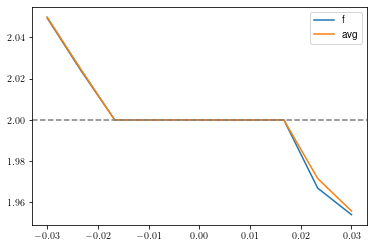

In [50]:
fig,axs = plt.subplots()
axs.plot(del_range21,fr_full21,label='f')
axs.plot(del_range21,fr_redu21,label='avg')
# axs.plot(del_range21,fr_redu21b,label='r')
# axs.plot(del_range21,fr_redu21c,label='r-t')
axs.axhline(2,0,1,color='gray',ls='--')
axs.legend()

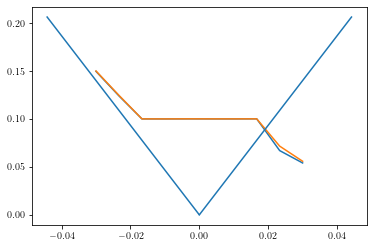

In [51]:
fig,axs = plt.subplots()
axs.plot(del_range21,fr_full21-2+eps_val21)
axs.plot(del_range21,fr_redu21-2+eps_val21)

axs.plot(del_list_21a,ve_list_21a,color='tab:blue')
axs.plot(del_list_21b,ve_list_21b,color='tab:blue')

* Okay when the full freq ratio appears to be shifted relative to the reduced freq, it might be because the om_fix term is messing things up somewhere. So far this is the most plausible explanation for all the shifts. Note that the response requires om_fix to exist in the rhs, but the response functions, when using them in the integration of the reduced models, do not require om_fix. Also, the forcing function needs to be multiplied by both omx and om_fix, but I can do this explicitly for now.

In [62]:
etemp = .05
dtemp = -.02
args21 = [a21,etemp,dtemp]

solf21 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args21,),**kw_sim)    
solr21a = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args21,),**kw_sim)
# solr21b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args21,),**kw_sim)

tp21_temp, phase21_temp = get_phase(solf21.t,solf21.y.T,skipn=20,system1=system1)

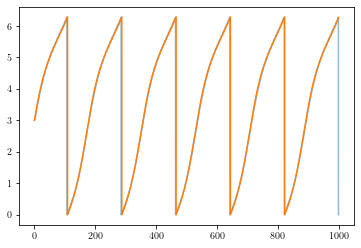

In [63]:
fig,axs = plt.subplots()
axs.plot(tp21_temp,np.mod(phase21_temp-tp21_temp*a21._n[1]*(1+dtemp),2*np.pi),alpha=.5)
axs.plot(t,np.mod(solr21a.y.T[:,0],2*np.pi))
# axs.plot(t,np.mod(solr21b.y.T[:,0]-t*a21._n[1]*(1+dtemp),2*np.pi))

# axs.set_xlim(t[-1]-50,t[-1])
#axs.set_xlim(0,50)

## Verify

In [64]:
eps21 = .05
del21 = 0.0
th_init21 = 3
ps_init21 = 0

In [65]:
dt = .01;T=500
t = np.arange(0,T,dt)

init21 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

args21 = [a21,eps21,del21]

solf21 = solve_ivp(_full,[0,t[-1]],init21,t_eval=t,args=(*args21,),**kw_sim)

In [66]:
solr21 = solve_ivp(rhs_avg,[0,t[-1]],[th_init21,ps_init21],t_eval=t,args=(*args21,),**kw_sim)

In [67]:
# solq21 = solve_ivp(_redu,[0,t[-1]],[th_init21,ps_init21,0],t_eval=t,args=(*args21,),**kw_sim)

In [68]:
# solw21 = solve_ivp(_redu_moving,[0,t[-1]],[th_init21,ps_init21,0],t_eval=t,args=(*args21,),**kw_sim)

In [69]:
# solx21 = solve_ivp(_redu_moving_avg,[0,t[-1]],[th_init21,ps_init21,0],t_eval=t,args=(*args21,),**kw_sim)

In [70]:
# soly21 = solve_ivp(_redu_moving_avg2,[0,t[-1]],[th_init21,ps_init21,0],t_eval=t,args=(*args21,),**kw_sim)

In [ ]:
fig,axs = plt.subplots(figsize=(15,2))
axs.plot(t,solf21.y.T[:,0])
axs.plot(t,a21.system1.forcing_fn(t*(a21._m[1]+del21)))
axs.set_xlim(t[-1]-100,t[-1])

In [72]:
# estimate phase for each model and compare phase difference
tp21, phase21 = get_phase(solf21.t,solf21.y.T,skipn=20,system1=system1)
#phase1 = np.arctan2(sol_full.y.T[:,1],sol_full.y.T[:,0])

(0.0, 6.283185307179586)

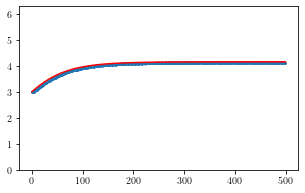

In [73]:
fig,axs = plt.subplots(figsize=(5,3));axs = np.asarray([axs])
#forcing_phase = np.mod((a._m[1]+del11)*np.linspace(0,t[-1],len(phase1)),2*np.pi)
forcing_phase21 = np.mod((a21._m[1]+del21)*np.linspace(0,tp21[-1],len(tp21)),2*np.pi*a21._m[1])
y21 = phase21-a21.om*forcing_phase21

#axs[0].scatter(tp12,np.mod(y12,np.pi),s=1,alpha=.5,label='full')

axs[0].scatter(tp21,np.mod(y21,2*np.pi/a21._m[1]),s=1)
axs[0].plot(solr21.t,np.mod(solr21.y.T[:,0],2*np.pi),color='r')
# axs.plot(solr21_0.t,np.mod(solr21_0.y.T[:,0],2*np.pi),color='g')

# axs[0].scatter(solq21.t[::50],np.mod(solq21.y.T[::50,0]-a21._n[1]*solq21.y.T[::50,2],a21._n[1]*2*np.pi),color='orange',alpha=.5,s=1,label='redu')
# axs[0].plot(solw21.t,np.mod(conv(solw21.y.T[:,0]),a21._n[1]*2*np.pi),color='gray',alpha=.75,label='r no move')
# axs[0].plot(solx21.t,np.mod(solx21.y.T[:,0],a21._n[1]*2*np.pi),color='b',alpha=.75,label='redu avg') #redu avg
# axs[0].plot(soly21.t,np.mod(soly21.y.T[:,0],a21._n[1]*2*np.pi),color='purple',alpha=.75,label='redu avg2') #redu avg 2

# axs[1].plot(solq21.t,conv(solq21.y.T[:,1]),color='orange',alpha=.5,label='redu')
# axs[1].plot(solw21.t,conv(solw21.y.T[:,1]),label='r no move',alpha=.5,color='gray')
# axs[1].plot(solx21.t,solx21.y.T[:,1],label='r avg',color='b') #redu avg
# axs[1].plot(soly21.t,soly21.y.T[:,1],label='r avg2',color='purple') #redu avg 2


axs[0].set_ylim(0,2*np.pi)

# axs[0].legend()
# axs[1].legend()

# 3:1

In [75]:
a31 = nmc(system1,None,
        _n=('om0',3),_m=('om1',1),
        NP=500,NH=500)

e1,e2
psi**6*zx0_6(t) + psi**5*zx0_5(t) + psi**4*zx0_4(t) + psi**3*zx0_3(t) + psi**2*zx0_2(t) + psi*zx0_1(t) + zx0_0(t)
psi**6*ix0_6(t) + psi**5*ix0_5(t) + psi**4*ix0_4(t) + psi**3*ix0_3(t) + psi**2*ix0_2(t) + psi*ix0_1(t) + ix0_0(t)

0 imp0 for z zx0_0(th0)
0 imp0 for i ix0_0(th0)
1 imp0 for z zx0_1(th0)
1 imp0 for i ix0_1(th0)
2 imp0 for z zx0_2(th0)
2 imp0 for i ix0_2(th0)
3 imp0 for z zx0_3(th0)
3 imp0 for i ix0_3(th0)
4 imp0 for z zx0_4(th0)
4 imp0 for i ix0_4(th0)
5 imp0 for z zx0_5(th0)
5 imp0 for i ix0_5(th0)
6 imp0 for z zx0_6(th0)
6 imp0 for i ix0_6(th0)

hz0,hi0,imp
0 uf(t)*zx0_0(3*t + th0)
1 uf(t)*zx0_1(3*t + th0)
2 uf(t)*zx0_2(3*t + th0)
3 uf(t)*zx0_3(3*t + th0)
4 uf(t)*zx0_4(3*t + th0)
5 uf(t)*zx0_5(3*t + th0)
6 uf(t)*zx0_6(3*t + th0)

0 ix0_0(3*t + th0)*uf(t)
1 ix0_1(3*t + th0)*uf(t)
2 ix0_2(3*t + th0)*uf(t)
3 ix0_3(3*t + th0)*uf(t)
4 ix0_4(3*t + th0)*uf(t)
5 ix0_5(3*t + th0)*uf(t)
6 ix0_6(3*t + th0)*uf(t)



## Tongue

In [76]:
d1 = np.linspace(-15,0,10,endpoint=False)
#dtemp = np.linspace(-1e-3,1e-3,31)

del_list_31a,ve_list_31a = get_tongue(2**d1,a31,deps=.01,max_eps=.3)
del_list_31b,ve_list_31b = get_tongue(-2**d1,a31,deps=.01,max_eps=.3)

1.0     
1.0     


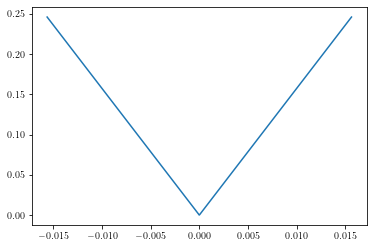

In [77]:
fig,axs = plt.subplots()
axs.plot(del_list_31a,ve_list_31a,color='tab:blue')
axs.plot(del_list_31b,ve_list_31b,color='tab:blue')
#axs.set_xscale('symlog')
#axs.set_xscale('log')
#axs.set_xlim(4e-6,2e-5)

## Frequency ratio

In [80]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val31 = .1

del_range31 = np.linspace(-.04,.04,15)

th_init = 3

dt = .01;T=500
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

fr_full31 = []
fr_redu31 = []
fr_redu31b = []

for i in range(len(del_range31)):
    
    args31 = [a31,eps_val31,del_range31[i]]
    
    solf31 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args31,),**kw_sim)
    solr31a = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args31,),**kw_sim)
    # solr31b = solve_ivp(_redu,[0,t[-1]],[th_init*a31._m[1],0,0],t_eval=t,args=(*args31,),**kw_sim)
    #solr31_0 = solve_ivp(rhs_avg,[0,t[-1]],[th_init,0],t_eval=t,args=(*args31,1),**kw_sim)

    timef = t*(a31._m[1]+del_range31[i])
    timer = a31._n[1]*t*(1+del_range31[i])
    freq_force = freq_est(t,a31.system1.forcing_fn(timef))
    freq_full = freq_est(t,solf31.y.T[:,0])
    freq_redu = freq_est(t,np.mod(solr31a.y.T[:,0]+timer,2*np.pi))
    # freq_redub = freq_est(t,np.mod(solr31b.y.T[:,0],2*np.pi))
    
    print(del_range31[i],freq_full/freq_force,freq_redu/freq_force)

    # fig,axs = plt.subplots()
    # axs.plot(t,solf31.y.T[:,0])
    # axs.plot(t,np.mod(solr31a.y.T[:,0],2*np.pi))
    # axs.plot(t,a31.system2(t*(a31._m[1]+del_range[i])))
    # axs.set_xlim(t[-1]-50,t[-1])
    # axs.scatter(t[peak_idxs_full],solf31.y.T[peak_idxs_full,0])
    # axs.scatter(t[peak_idxs_full],np.mod(solr31a.y.T[peak_idxs_full,0],2*np.pi))
    # plt.show()

    fr_full31.append(freq_full/freq_force)
    fr_redu31.append(freq_redu/freq_force)
    # fr_redu31b.append(freq_redub/freq_force)

fr_full31 = np.asarray(fr_full31)
fr_redu31 = np.asarray(fr_redu31)
# fr_redu31b = np.asarray(fr_redu31b)

-0.04 3.1242958978395867 3.1243574996232546
-0.03428571428571429 3.1047608506870543 3.1053285964279005
-0.028571428571428574 3.085054282498761 3.085382320549228
-0.022857142857142857 3.0693380228614493 3.06989214390385
-0.017142857142857144 3.048418245160302 3.0486646417206935
-0.01142857142857143 3.0289403918644626 3.0289403918644626
-0.005714285714285713 3.00092253207192 3.0008017657420045
0.0 2.9999845678536046 2.9999845678536046
0.005714285714285713 2.995589607217795 2.9995779255038517
0.011428571428571427 2.9701270204283463 2.9716791228227497
0.01714285714285714 2.9511130515074875 2.951824077420391
0.02285714285714286 2.9358096710711274 2.936163439910026
0.028571428571428574 2.9160465722652327 2.9169826652221014
0.03428571428571429 2.901329467009151 2.901795319524728
0.04 2.8860114432069173 2.886590800705454


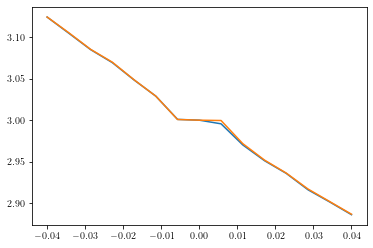

In [81]:
fig,axs = plt.subplots()
axs.plot(del_range31,fr_full31)
axs.plot(del_range31,fr_redu31)
# axs.plot(del_range31,fr_redu31b)

## Verify

In [119]:
eps31 = .2
del31 = 0.005
th_init31 = 3
ps_init31 = 0

In [120]:
dt = .01;T=500
t = np.arange(0,T,dt)

init31 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

args31 = [a31,eps31,del31]

solf31 = solve_ivp(_full,[0,t[-1]],init31,t_eval=t,args=(*args31,),**kw_sim)

In [121]:
# solq31 = solve_ivp(_redu,[0,t[-1]],[th_init31,ps_init31,0],t_eval=t,args=(*args31,),**kw_sim)

In [122]:
solr31 = solve_ivp(rhs_avg,[0,t[-1]],[th_init31,ps_init31],t_eval=t,args=(*args31,),**kw_sim)

In [123]:
# solw31 = solve_ivp(_redu_moving,[0,t[-1]],[th_init31,ps_init31,0],t_eval=t,args=(*args31,),**kw_sim)

In [124]:
# solx31 = solve_ivp(_redu_moving_avg,[0,t[-1]],[th_init31,ps_init31,0],t_eval=t,args=(*args31,),**kw_sim)

In [125]:
# soly31 = solve_ivp(_redu_moving_avg2,[0,t[-1]],[th_init31,ps_init31,0],t_eval=t,args=(*args31,),**kw_sim)

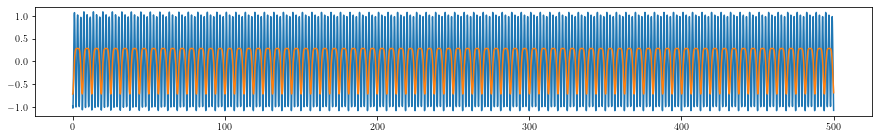

In [126]:
fig,axs = plt.subplots(figsize=(15,2))
axs.plot(t,solf31.y.T[:,0])
axs.plot(t,a31.system1.forcing_fn(t*(a31._m[1]+del31)))
#axs.set_xlim(t[-1]-300,t[-1])

In [127]:
# estimate phase for each model and compare phase difference
tp31, phase31 = get_phase(solf31.t,solf31.y.T,skipn=20,system1=system1)
#phase1 = np.arctan2(sol_full.y.T[:,1],sol_full.y.T[:,0])

(0.0, 6.283185307179586)

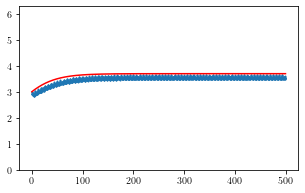

In [128]:
fig,axs = plt.subplots(figsize=(5,3));axs = np.asarray([axs])
#forcing_phase = np.mod((a._m[1]+del11)*np.linspace(0,t[-1],len(phase1)),2*np.pi)
forcing_phase31 = np.mod((a31._m[1]+del31)*np.linspace(0,tp31[-1],len(tp31)),2*np.pi*a31._m[1])
y31 = np.mod(phase31-a31.om*forcing_phase31,2*np.pi)

#axs[0].scatter(tp12,np.mod(y12,np.pi),s=1,alpha=.5,label='full')

axs[0].scatter(tp31,y31,s=1)
axs[0].plot(solr31.t,np.mod(solr31.y.T[:,0],2*np.pi),color='r')
# axs.plot(solr31_0.t,np.mod(solr31_0.y.T[:,0],2*np.pi),color='g')

# axs[0].scatter(solq31.t[::50],np.mod(solq31.y.T[::50,0]-a31._n[1]*solq31.y.T[::50,2],a31._n[1]*2*np.pi),color='orange',alpha=.5,s=1,label='redu')
# axs[0].plot(solw31.t,np.mod(conv(solw31.y.T[:,0]),a31._n[1]*2*np.pi),color='gray',alpha=.75,label='r no move')
# axs[0].plot(solx31.t,np.mod(solx31.y.T[:,0],a31._n[1]*2*np.pi),color='b',alpha=.75,label='redu avg') #redu avg
# axs[0].plot(soly31.t,np.mod(soly31.y.T[:,0],a31._n[1]*2*np.pi),color='purple',alpha=.75,label='redu avg2') #redu avg 2

# axs[1].plot(solq31.t,conv(solq31.y.T[:,1]),color='orange',alpha=.5,label='redu')
# axs[1].plot(solw31.t,conv(solw31.y.T[:,1]),label='r no move',alpha=.5,color='gray')
# axs[1].plot(solx31.t,solx31.y.T[:,1],label='r avg',color='b') #redu avg
# axs[1].plot(soly31.t,soly31.y.T[:,1],label='r avg2',color='purple') #redu avg 2


axs[0].set_ylim(0,2*np.pi)

# axs[0].legend()
# axs[1].legend()

# All tongues

[Text(1.0, 0, '$1{:}1$'), Text(2.0, 0, '$2{:}1$'), Text(3.0, 0, '$3{:}1$')]

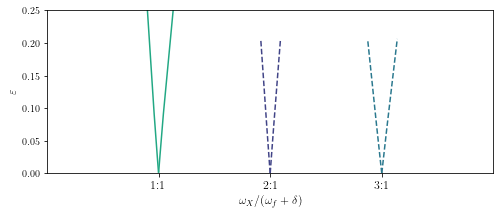

In [129]:
#fig,axs = plt.subplots()
import matplotlib
cmap = matplotlib.colormaps['viridis']
fsize = 12

fig,axs = plt.subplots(figsize=(8,3))

axs.plot(2/(del_list_21a+1),ve_list_21a,color=cmap(.2),label='2:1',ls='--')
axs.plot(2/(del_list_21b+1),ve_list_21b,color=cmap(.2),ls='--')

axs.plot(3/(del_list_31a+1),ve_list_21a,color=cmap(.4),label='3:1',ls='--')
axs.plot(3/(del_list_31b+1),ve_list_21b,color=cmap(.4),ls='--')

#axs.plot((del_list_13a+3)/1,ve_list_13a,color=cmap(0),label='1:3',ls='-.')
#axs.plot((del_list_13b+3)/1,ve_list_13b,color=cmap(0),ls='-.')

#axs.plot((del_list_12a+2)/1,ve_list_12a,color=cmap(.2),label='1:2',ls='--')
#axs.plot((del_list_12b+2)/1,ve_list_12b,color=cmap(.2),ls='--')

#axs.plot((del_list_23a+3)/2,ve_list_23a,color=cmap(.4),label='2:3',ls=':')
#axs.plot((del_list_23b+3)/2,ve_list_23b,color=cmap(.4),ls=':')

axs.plot(1/(del_list_11a+1),ve_list_11a,label='1:1',color=cmap(.6))
axs.plot(1/(del_list_11b+1),ve_list_11b,label='1:1',color=cmap(.6))

axs.set_xlim(0,4)
axs.set_ylim(0,.25)

#axs.set_yscale('log')
axs.set_xlabel(r'$\omega_X/(\omega_f+\delta)$',fontsize=fsize)
axs.set_ylabel(r'$\varepsilon$',fontsize=fsize)

axs.set_xticks([1/1,2/1,3/1])
axs.set_xticklabels(['$1{:}1$','$2{:}1$','$3{:}1$'],fontsize=fsize)

#plt.savefig('../')